In [1]:
import sys
import os


current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import pandas as pd
from sklearn.model_selection import train_test_split
import timm
import matplotlib.pyplot as plt
from dataloader import EmotionDataset

c:\Users\64698\anaconda3\envs\cs178\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class DeiT(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()

        self.model = timm.create_model('deit_tiny_distilled_patch16_224', pretrained=pretrained)
        
        n_inputs = self.model.head.in_features
        self.model.head = nn.Linear(n_inputs, num_classes)
        self.model.head_dist = nn.Linear(n_inputs, num_classes)

    def forward(self, x):

        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)

        return self.model(x)

In [ ]:
# === Hyperparameters ===
max_epoch = 15
learning_rate = 5e-5
BATCH_SIZE = 32
output_dim = 8
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:

data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    # Normalize from ImageNet
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
full_data = pd.read_csv('../data/legend.csv') 
full_data['label_idx'] = full_data['emotion'].str.lower()
unique_labels = sorted(full_data['label_idx'].unique())
label_to_int = {label: i for i, label in enumerate(unique_labels)}
full_data['label_idx'] = full_data['label_idx'].map(label_to_int)

train_df, val_df = train_test_split(full_data, test_size=0.2, stratify=full_data['emotion'], random_state=42)

train_dataset = EmotionDataset(train_df, '../images/', transform=data_transform)
val_dataset = EmotionDataset(val_df, '../images/', transform=data_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

In [7]:
model = DeiT(num_classes=output_dim).to(device)
criterion = nn.CrossEntropyLoss()


optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)

In [8]:
# training loop
training_loss = []
training_acc = []
val_loss = []
val_accuracy = []
print("Start Training DeiT...")
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_dataset)

    training_loss.append(epoch_loss)
    training_acc.append(100*correct/total)

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    validation_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            validation_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_epoch_loss = validation_loss / len(val_dataset)
    val_loss.append(val_epoch_loss)
    val_acc = 100 * val_correct / val_total
    val_accuracy.append(val_acc)

    print(
        f"Epoch {epoch+1}/{max_epoch} | Loss: {epoch_loss:.4f} | Val Acc: {val_acc:.2f}%")

# Save
torch.save(model.state_dict(), 'emotion_deit_model.pth')
print("Training Finished.")

Start Training DeiT...
Epoch 1/15 | Loss: 0.5896 | Val Acc: 83.75%
Epoch 2/15 | Loss: 0.3806 | Val Acc: 85.54%
Epoch 3/15 | Loss: 0.2820 | Val Acc: 83.42%
Epoch 4/15 | Loss: 0.1984 | Val Acc: 84.04%
Epoch 5/15 | Loss: 0.1243 | Val Acc: 86.05%
Epoch 6/15 | Loss: 0.0689 | Val Acc: 85.21%
Epoch 7/15 | Loss: 0.0443 | Val Acc: 85.39%
Epoch 8/15 | Loss: 0.0676 | Val Acc: 85.72%
Epoch 9/15 | Loss: 0.0254 | Val Acc: 85.17%
Epoch 10/15 | Loss: 0.0344 | Val Acc: 84.33%
Epoch 11/15 | Loss: 0.0454 | Val Acc: 86.30%
Epoch 12/15 | Loss: 0.0284 | Val Acc: 85.21%
Epoch 13/15 | Loss: 0.0192 | Val Acc: 86.30%
Epoch 14/15 | Loss: 0.0297 | Val Acc: 86.19%
Epoch 15/15 | Loss: 0.0320 | Val Acc: 85.43%
Training Finished.


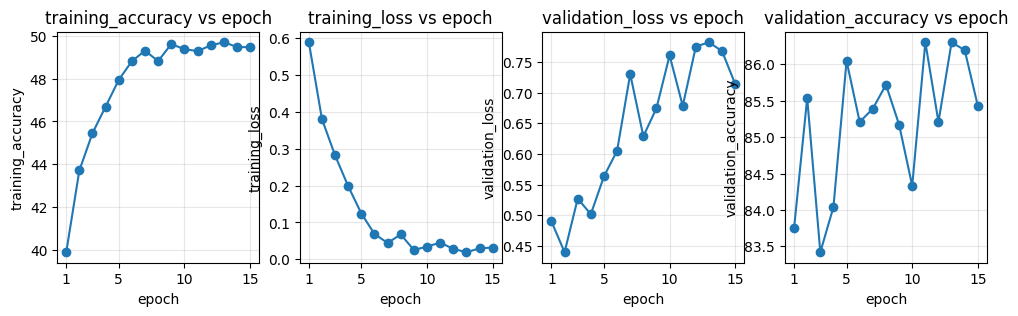

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3))

axes[0].plot(range(1, len(training_acc)+1), training_acc, marker='o')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel("training_accuracy")
axes[0].set_title('training_accuracy vs epoch')
axes[0].set_xticks([1, 5, 10, 15])
axes[0].grid(True, alpha=0.3)

axes[1].plot(range(1, len(training_loss)+1), training_loss, marker='o')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel("training_loss")
axes[1].set_title('training_loss vs epoch')
axes[1].set_xticks([1, 5, 10, 15])
axes[1].grid(True, alpha=0.3)

axes[2].plot(range(1, len(val_loss)+1), val_loss, marker='o')
axes[2].set_xlabel('epoch')
axes[2].set_ylabel("validation_loss")
axes[2].set_title('validation_loss vs epoch')
axes[2].set_xticks([1, 5, 10, 15])
axes[2].grid(True, alpha=0.3)

axes[3].plot(range(1, len(val_accuracy)+1), val_accuracy, marker='o')
axes[3].set_xlabel('epoch')
axes[3].set_ylabel("validation_accuracy")
axes[3].set_title('validation_accuracy vs epoch')
axes[3].set_xticks([1, 5, 10, 15])
axes[3].grid(True, alpha=0.3)

In [1]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=unique_labels, yticklabels=unique_labels[::-1])
plt.title('Normalized Confusion Matrix (%)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\nPer-class accuracy:")
for i, label in enumerate(unique_labels):
    print(f"{label}: {cm_normalized[i, i]:.2f}%")

# f1-score
from sklearn.metrics import f1_score
f1 = f1_score(all_labels, all_predictions, average='weighted')
print(f"\nWeighted F1-Score: {f1:.4f}")

NameError: name 'model' is not defined